In [1]:
import os
import re
import sqlite3
import pandas as pd
import numpy as np
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def recover_table_data(table_name, conn):
    try:
        # Attempt to export the entire table
        table_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        print(f"Exported {table_name} successfully")
        return table_df
    except sqlite3.DatabaseError as e:
        print(f"Error exporting table {table_name}: {e}")
        # Attempt to export data in chunks
        return export_table_in_chunks(table_name, conn)

def export_table_in_chunks(table_name, conn, chunk_size=10):
    offset = 0
    chunk_num = 0
    combined_df = pd.DataFrame()
    while True:
        try:
            query = f"SELECT * FROM {table_name} LIMIT {chunk_size} OFFSET {offset}"
            chunk_df = pd.read_sql_query(query, conn)
            if chunk_df.empty:
                break
            combined_df = pd.concat([combined_df, chunk_df], ignore_index=True)
            print(f"Exported chunk {chunk_num} of {table_name} successfully", end='\r')
            offset += chunk_size
            chunk_num += 1
        except sqlite3.DatabaseError as e:
            print(f"Error exporting chunk {chunk_num} of table {table_name}: {e}")
            break
    return combined_df


def recover_database(db_path):
    # Attempt to connect to the corrupted database
    try:
        conn = sqlite3.connect(db_path)
        print("Connected to the database successfully")
    except sqlite3.DatabaseError as e:
        print(f"Database connection error: {e}")
        return pd.DataFrame()

    # Query the list of tables in the database
    try:
        tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
        tables = pd.read_sql_query(tables_query, conn)
    except sqlite3.DatabaseError as e:
        print(f"Error querying tables: {e}")
        conn.close()
        return pd.DataFrame()

    # Loop through all tables and concatenate each one into a single dataframe
    combined_df = pd.DataFrame()
    for table_name in tables['name']:
        table_df = recover_table_data(table_name, conn)
        combined_df = pd.concat([combined_df, table_df], ignore_index=True)

    # Close the connection
    conn.close()
    return combined_df

# Path to your SQLite database file
db_path = 'merged_data.sqlite'
combined_dataframe = recover_database(db_path)


Connected to the database successfully
Exported log successfully


In [2]:
combined_dataframe.columns

Index(['公告號', '公告日', '公報卷期', '證書號', '申請號', '申請日', '公報IPC', '當前IPC', '申請人',
       '當前專利權人', '發明人', '代理人', '當前代理人', '摘要'],
      dtype='object')

In [3]:
def build_label(year_list, company_list, start_year)->list:
    labels = []
    total_length = len(year_list)
    for idx, (year, company) in enumerate(zip(year_list, company_list)):
        if idx<total_length-1:
            next_year = year_list[idx+1]
            next_company = company_list[idx+1]
            if company == next_company:
                if year == next_year:
                    labels.append(0)
                else:
                    labels.append(year-start_year+1) 
            else:
                labels.append(year-start_year+1)
        else:
            labels.append(year-start_year+1)
    return labels

def encode_label(df: pd.DataFrame, start_year:int) -> pd.DataFrame:
    company_dfs = df.groupby('company')
    encode_dfs = [] 
    for _, group_df in company_dfs:
        # Sort each group by timestamp1
        group_df = group_df.sort_values(by='timestamp2')
        # Assuming you have a function build_label defined elsewhere
        group_df['label'] = build_label(group_df['year'].tolist(), group_df['company'].tolist(), start_year=start_year)
        encode_dfs.append(group_df)
    # Concatenate the DataFrames in the list
    encoded_df = pd.concat(encode_dfs)
    return encoded_df

# Preprocess

In [4]:
def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Remove '\n' from all columns
    df = df.applymap(lambda x: re.sub(r'\n+', '', str(x)) if isinstance(x, str) else x)
    # df = df.apply(lambda x: re.sub(r'\n+', '', str(x)) if isinstance(x, str) else x)
    # Extract year, month, day from '申請日'
    df['timestamp'] = df['公告日']
    df['公告日'] = pd.to_datetime(df['公告日'], format="%Y/%m/%d", errors='coerce')
    df['timestamp'] = df['timestamp'].apply(lambda ts: re.sub(r'\/', '', str(ts)))
    df = df.dropna(subset=['公告日'])
    df['year'] = df['公告日'].dt.year
    df['month'] = df['公告日'].dt.month
    df['day'] = df['公告日'].dt.day
    # Filter rows where the year is between 2018 and 2023
    df = df[df['year'] >= 2018]
    df = df[df['year'] <= 2023]
    # Calculate 'timestamp2': month * 30 + day + (year - 2018) * 365
    df['timestamp2'] = df['month'] * 30 + df['day'] + (df['year'] - 2018) * 365
    # Calculate 'timestep1': timestamp2 * 86400
    df['timestamp1'] = df['timestamp2'] * 86400
    # Convert 公報IPC and 當前IPC into lists of IPC codes
    df['fields'] = df['當前IPC'].apply(lambda x: re.findall(r'[A-HK-Z]\d{2}[A-Z]?\s\d+/\d+', str(x)))
    df = df[df['fields'].apply(lambda x: len(x) > 0)] # delete empty list
    # Encode 當前專利權人 to company as 0, 1, 2, 3, ...
    df['company'] = df['當前專利權人'].astype('category').cat.codes
    # build labels
    df = encode_label(df, 2018)
    # select columns
    # must have: company,fields,timestamp,label,year,month,day,timestamp1,timestamp2,ts
    df = df[['company', 'fields', 'timestamp', 'label', 'year', 'month', 'day', 'timestamp1', 'timestamp2']]
    #df = df.sort_values(by=['timestamp2'])
    return df
combined_dataframe = preprocess_dataframe(combined_dataframe)
print(combined_dataframe.shape)
combined_dataframe.head()

/tmp/ipykernel_3155/1310106328.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(r'\n+', '', str(x)) if isinstance(x, str) else x)


(163733, 9)


,company,fields,timestamp,label,year,month,day,timestamp1,timestamp2
74469,0,"[B23K 26/066, B23K 26/064, B23K 26/362, B23K 1...",20180301,1,2018,3,1,7862400,91
70438,1,[H03K 5/003],20180501,0,2018,5,1,13046400,151
62357,1,"[G11C 7/18, G11C 17/14]",20180921,1,2018,9,21,25142400,291
55833,2,[G03F 9/00],20190101,2,2019,1,1,34214400,396
68614,3,"[C07H 1/06, B01D 15/36, C07H 3/02]",20180611,1,2018,6,11,16502400,191


# Build Input

## build real-data.json

In [5]:
company_ipc_dict = {}
for company in tqdm(combined_dataframe['company'].unique()):
    # Filter dataframe for the current company
    company_data = combined_dataframe[combined_dataframe['company'] == company]
    company_ipc_dict[str(company)] = {}
    for year in company_data['year'].unique():
        # Filter dataframe for the current year
        year_data = company_data[company_data['year'] == year]
        # Flatten the list of lists if necessary (in case each row contains a list of IPCs)
        ipc_list = list(set([item for sublist in  year_data['fields'].tolist() for item in sublist]))
        # Store the IPC list in the dictionary
        company_ipc_dict[str(company)][str(int(year)-2018)] = ipc_list
    for i in range(6):
        if str(i) not in company_ipc_dict[str(company)].keys():
            company_ipc_dict[str(company)][str(i)] = []
    # filter ensure all year exists
    for i in range(6):
        if company_ipc_dict[str(company)][str(i)] == []:
            del company_ipc_dict[str(company)]
            break

print(len(company_ipc_dict))

  0%|          | 0/21494 [00:00<?, ?it/s]

766


In [6]:
combined_dataframe.shape

(163733, 9)

In [7]:
# Filter the DataFrame to include only rows where 'company' is in company_ipc_dict keys
combined_dataframe.reset_index(drop=True, inplace=True)
remove_id = [i for i in tqdm(range(combined_dataframe.shape[0]))
             if str(combined_dataframe.iloc[i]['company']) not in company_ipc_dict]
combined_dataframe = combined_dataframe.drop(index=remove_id)
print(combined_dataframe.shape[0])
combined_dataframe['new_company_id'] = combined_dataframe['company'].astype('category').cat.codes
combined_dataframe

  0%|          | 0/163733 [00:00<?, ?it/s]

94775


,company,fields,timestamp,label,year,month,day,timestamp1,timestamp2,new_company_id
42,25,"[E05B 47/00, G06F 21/32]",20180211,0,2018,2,11,6134400,71,0
43,25,"[E05B 47/00, G06Q 10/00]",20180421,0,2018,4,21,12182400,141,0
44,25,"[E06B 3/67, E06B 7/28, G06K 9/62]",20181101,1,2018,11,1,28598400,331,0
45,25,"[E05B 47/00, G06F 21/32, G07C 9/00, H04N 21/4415]",20190611,0,2019,6,11,48038400,556,0
46,25,"[H04L 9/32, G06Q 10/06, G07C 9/00, G08B 25/00]",20190621,0,2019,6,21,48902400,566,0
...,...,...,...,...,...,...,...,...,...,...
162052,21001,[G01J 5/02],20231201,0,2023,12,1,188870400,2186,765
162053,21001,"[G01N 1/28, G01N 23/2202, G01N 23/2251]",20231201,0,2023,12,1,188870400,2186,765
162054,21001,"[C01B 32/168, B82Y 40/00, H01L 29/06, H01L 29/...",20231201,0,2023,12,1,188870400,2186,765
162055,21001,"[G06T 1/40, G06N 3/02]",20231201,0,2023,12,1,188870400,2186,765


In [8]:
# encode new company id to real-data
company_ipc_dict_final = {}
company_mapping  = {str(o):str(n) for o,n in zip(combined_dataframe['company'], combined_dataframe['new_company_id'])}
for key, value in company_ipc_dict.items():
    company_ipc_dict_final[company_mapping[key]] = value

In [9]:
# delete new_company_id column
combined_dataframe['company'] = combined_dataframe['new_company_id']
combined_dataframe = combined_dataframe[['company', 'fields', 'timestamp', 'label', 'year', 'month', 'day', 'timestamp1', 'timestamp2']]
combined_dataframe.reset_index(drop=True, inplace=True)
combined_dataframe.reset_index(inplace=True)
combined_dataframe.rename(columns={'index': 'ts'}, inplace=True)
combined_dataframe = combined_dataframe[['company', 'fields', 'timestamp', 'label', 'year', 'month', 'day', 'timestamp1', 'timestamp2', 'ts']]
combined_dataframe = combined_dataframe.sort_values(by=['timestamp2'])

## visualize

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

def plot_counts(count_dict: dict, font_path: str, y_label: str):
    # Define the font properties
    font_prop = FontProperties(fname=font_path)
    
    # Get the top 20 counts
    sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    top_20_count_dict = {str(key): value for key, value in sorted_counts}
    
    # Get unique count values and assign a color to each unique count
    unique_counts = sorted(set(top_20_count_dict.values()))
    color_map = plt.cm.viridis(np.linspace(0, 1, len(unique_counts)))
    color_dict = {count: color_map[i] for i, count in enumerate(unique_counts)}
    
    # Assign colors to bars based on count values
    colors = [color_dict[top_20_count_dict[key]] for key in top_20_count_dict.keys()]
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(list(top_20_count_dict.keys()), list(top_20_count_dict.values()), color=colors)
    plt.xlabel('Count')
    plt.ylabel(y_label)
    plt.title(f'Top 20 Counts of {y_label}')
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Add exact values to each bar
    for bar, value in zip(bars, list(top_20_count_dict.values())):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value}', 
                 va='center', ha='left', fontproperties=font_prop)

    plt.gca().invert_yaxis()
    plt.show()

def extract_unique_ipc_codes_and_counts(dataframe, column_name):
    ipc_counts = {}  # Initialize an empty dictionary to store IPC codes and their counts
    
    # Iterate over each row in the specified column
    for ipc_list in dataframe[column_name]:
        # Flatten the tuple and count individual IPC codes
        for ipc_code in ipc_list:
            if ipc_code in ipc_counts:
                ipc_counts[ipc_code] += 1
            else:
                ipc_counts[ipc_code] = 1
    
    return ipc_counts


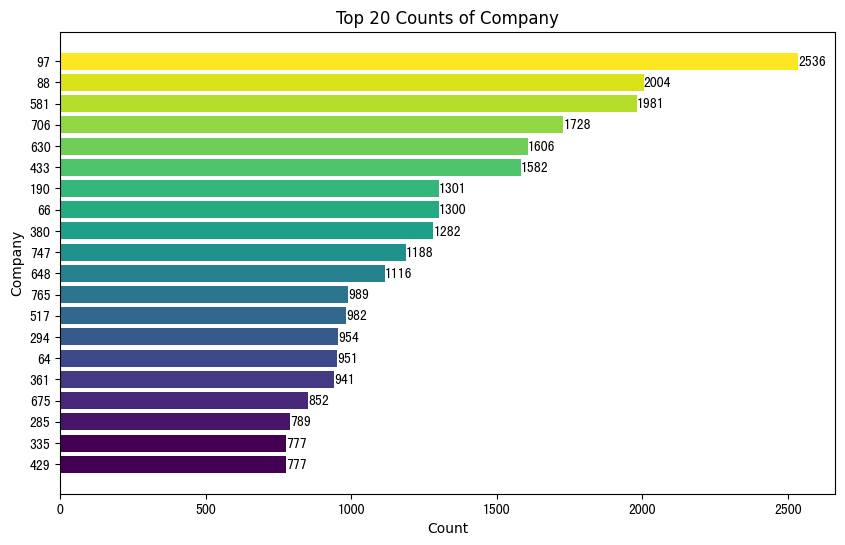

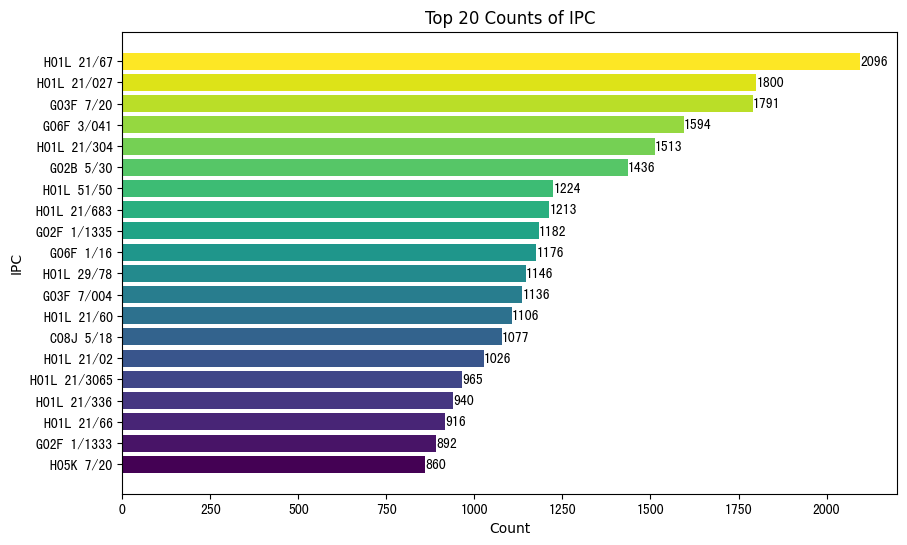

In [11]:
applicant_counts = combined_dataframe['company'].value_counts().to_dict()
plot_counts(applicant_counts, 'font/SimHei.ttf', 'Company')

ipc_counts = extract_unique_ipc_codes_and_counts(combined_dataframe, 'fields')
plot_counts(ipc_counts, 'font/SimHei.ttf', 'IPC')
ipc_list = list(ipc_counts.keys())

## build level.csv

In [12]:
def parse_ipc_code(ipc_code):
    match = re.match(r'^([A-H]+?)(\d+?)([A-Z]+?) *(\d+?)\/(\d+?)$', ipc_code)
    if match:
        level1 = match.group(1)
        level2 = level1 + match.group(2)
        level3 = level2 + match.group(3)
        level4 = level3 + " " + match.group(4)
        level5 = level4 + "/" + match.group(5)
        return level1, level2, level3, level4, level5
    else:
        raise ValueError("Invalid IPC code format")
    
def get_level_sets(ipc_list):
    level2_set = set()
    level3_set = set()
    level4_set = set()
    level5_set = set()
    for ipc_code in ipc_list:
        level1, level2, level3, level4, level5 = parse_ipc_code(ipc_code)
        level2_set.add(level2)
        level3_set.add(level3)
        level4_set.add(level4)
        level5_set.add(level5)
    return level2_set, level3_set, level4_set, level5_set

def encode_level_id(level2_set, level3_set, level4_set, level5_set):
    level1_mapping = {'A': 0, 'B': 1, 'H': 2, 'C': 3, 'F': 4, 'G': 5, 'D': 6, 'E': 7}
    level2_mapping = {value: key for key, value in enumerate(level2_set)}
    level3_mapping = {value: key for key, value in enumerate(level3_set)}
    level4_mapping = {value: key for key, value in enumerate(level4_set)}
    level5_mapping = {value: key for key, value in enumerate(level5_set)}
    return level1_mapping, level2_mapping, level3_mapping, level4_mapping, level5_mapping

def generate_mapping(source_set, 
                     source_level:int, 
                     level1_mapping=None, 
                     level2_mapping=None, 
                     level3_mapping=None, 
                     level4_mapping=None):
    mapping = {}
    for source_code in source_set:
        if source_level==2:
            prefix = level1_mapping[source_code[0]]
        elif source_level==3:
            prefix = level2_mapping[re.match(r'^([A-H]+\d{2,3}?)', source_code).group(0)]
        elif source_level==4:
            prefix = level3_mapping[re.match(r'^([A-H]+\d+[A-Z]+?)', source_code).group(0)]
        elif source_level==5:
            prefix = level4_mapping[re.match(r'^([A-H]+\d+[A-Z]+ *\d+?)\/', source_code).group(1)]
        mapping[source_code] = prefix             
    return mapping

def encode_fields(field_list, mapping):
    '''encode 'fields' for dataframe
    '''
    return [mapping[item] for item in field_list]

In [13]:
def build_data(output_folder:str, combined_dataframe:pd.DataFrame, real_data_dict:dict):
    '''
    'field' 在這才能完成
    '''
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    data = {
        "2-1": [],
        "3-2": [],
        "4-3": [],
        "5-4": []
    }
    level2_set, level3_set, level4_set, level5_set = get_level_sets(ipc_list)
    level1_mapping, level2_mapping, level3_mapping, level4_mapping, level5_mapping = encode_level_id(level2_set, level3_set, level4_set, level5_set)
    # Generate mappings
    level2_to_level1_mapping = generate_mapping(level2_set, source_level=2, level1_mapping=level1_mapping)
    level3_to_level2_mapping = generate_mapping(level3_set, source_level=3, level2_mapping=level2_mapping)
    level4_to_level3_mapping = generate_mapping(level4_set, source_level=4, level3_mapping=level3_mapping)
    level5_to_level4_mapping = generate_mapping(level5_set, source_level=5, level4_mapping=level4_mapping)
    for idx, (node, value) in enumerate(level2_to_level1_mapping.items()):
        data["2-1"].append((node, idx, value))
    for idx, (node, value) in enumerate(level3_to_level2_mapping.items()):
        data["3-2"].append((node, idx, value))
    for idx, (node, value) in enumerate(level4_to_level3_mapping.items()):
        data["4-3"].append((node, idx, value))
    for idx, (node, value) in enumerate(level5_to_level4_mapping.items()):
        data["5-4"].append((node, idx, value))
    for key, value in data.items():
        if key == "2-1":
            df = pd.DataFrame(value, columns=["node", "id2", "id1"])
            file_path = os.path.join(output_folder, f"{key}-level.csv")
            df.to_csv(file_path, index_label="")
        if key == "3-2":
            df = pd.DataFrame(value, columns=["node", "id3", "id2"])
            file_path = os.path.join(output_folder, f"{key}-level.csv")
            df.to_csv(file_path, index_label="")
        if key == "4-3":
            df = pd.DataFrame(value, columns=["node", "id4", f"id3"])
            file_path = os.path.join(output_folder, f"{key}-level.csv")
            df.to_csv(file_path, index_label="")
        if key == "5-4":
            df = pd.DataFrame(value, columns=["node", "id5", f"id4"])
            file_path = os.path.join(output_folder, f"{key}-level.csv")
            df.to_csv(file_path, index_label="")
    combined_dataframe['fields'] = combined_dataframe['fields'].apply(lambda x: encode_fields(x, level5_mapping))
    file_path = os.path.join(output_folder, "data-time-fin.csv")
    combined_dataframe.to_csv(file_path, index=False)
    for company, year_dict in real_data_dict.items():
        for year, _ipc_list in year_dict.items():
            real_data_dict[company][year] = [level5_mapping[ipc] for ipc in _ipc_list]
    with open(os.path.join(output_folder,'real-data.json'), 'w', encoding='utf-8') as file:
        json.dump(company_ipc_dict_final, file, ensure_ascii=False, indent=4)

In [14]:
dest_folder = "EDGPAT/data"
build_data(dest_folder, combined_dataframe, company_ipc_dict_final)